# 1 - Financial Portfolios in Python

<br>

## Questions to address:
- Compute basic return statistics
- Compute Returns for different portfolios
- Understand how much of returns can be explained by CAPM and FamaFrench models
- Understand risk

<br>

## Tools:
- mean, skew, kurtosis and shapiro test
- Equal Weights Portfolio, Market cap weighted and Markowitz Portfolios (MSR and GMV)
- CAPM and FamaFrench 3 and 5 factors models
  - statsmodels ordinary least squares, r_squared and p_values
- value ate risk and conditional value at risk

<br>

### load defaults

In [117]:
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

#Project specific
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import shapiro
from scipy.stats import norm

import statsmodels.formula.api as smf 

print("Defaults Loaded")

Defaults Loaded


## 1 - Returns stats

**Mean and Variance**

Annual Mean of Returns: 0.100%
Annual Variance of Returns: 0.094%


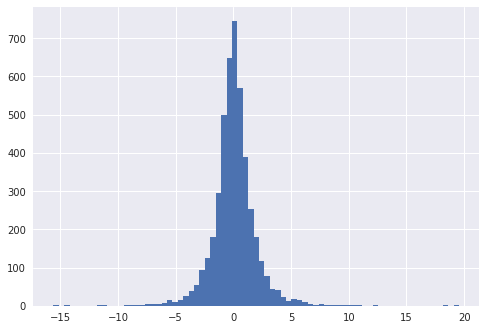

In [17]:
#return = (price_2 - price_1)/price_2
StockPrices = pd.read_csv('./data/MSFTPrices.csv', parse_dates=['Date'])
StockPrices = StockPrices.sort_values(by='Date')

# Calculate the daily returns of the adjusted close price
StockPrices['Returns'] = StockPrices['Adjusted'].pct_change()

#Mean and variance
mean_return_daily = np.mean(StockPrices['Returns'])
#implied annualized average return
mean_return_annualized = ((1+mean_return_daily)**252)-1
print(f"Annual Mean of Returns: {mean_return_annualized:0.3f}%")

sigma_return_daily = np.std(StockPrices['Returns'])**2
#implied annualized variance
sigma_return_annualized = sigma_return_daily*np.sqrt(252)**2
print(f"Annual Variance of Returns: {sigma_return_annualized:0.3f}%")


plt.hist(StockPrices['Returns'].dropna()*100., bins=75, density=None)
plt.show()

**Skewness, Kurtosis and Shapiro-wilk test (to test normal hypothesis)**

In [18]:
returns_skewness = skew(StockPrices["Returns"].dropna())
#high kurtosis: a lot of outliers
excess_kurtosis = kurtosis(StockPrices["Returns"].dropna())

p_value = shapiro(StockPrices["Returns"].dropna())[1]
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


<br>
<br>
<br>

## 2 - Portfolio Investing 
-**Equal Weights Portfolio, Market cap weighted and Markowitz Portfolios (MSR and GMV)**

In [75]:
df = pd.read_csv('./data/EfficientFrontierPortfoliosSlim.csv')

#get date from other file
df_aux = pd.read_csv('./data/Big9Returns2017.csv')
df['Date'] = pd.to_datetime(df_aux['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
display(df[:2])

,AAPL weight,MSFT weight,XOM weight,JNJ weight,JPM weight,AMZN weight,GE weight,FB weight,T weight,Returns,Volatility
Date,,,,,,,,,,,
2017-01-03,0.000053,0.263110,0.007022,0.040087,0.000027,0.024316,0.355899,0.299400,0.010087,0.127453,0.171565
2017-01-04,0.042360,0.034922,0.079355,0.043057,0.001435,0.202032,0.225924,0.362324,0.008590,0.138614,0.182723


In [76]:
numstocks = 5
risk_free = 0 

**Equal Weights Portfolio:**

In [77]:
portfolio_weights_ew = np.repeat(1/numstocks, numstocks)
df['Portfolio_EW_Returns'] = df.iloc[:, :numstocks].mul(portfolio_weights_ew, axis=1).sum(axis=1)

**Market cap weighted (weight by value of all shares of a company):**

In [78]:
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])
mcap_weights = market_capitalizations[:numstocks]/sum(market_capitalizations[:numstocks])
df['Portfolio_MCap_Returns'] = df.iloc[:, 0:numstocks].mul(mcap_weights, axis=1).sum(axis=1)

**MSR portfolios**: stock weight is the maximum value of Sharpe for a given stock

In [79]:
#Sort the stocks by Sharpe
df["Sharpe"] = (df["Returns"]-risk_free)/df["Volatility"]
sorted_portfolios = df.sort_values(by=['Sharpe'], ascending=False)

MSR_weights = sorted_portfolios.iloc[0,0:numstocks]
MSR_weights_array = np.array(MSR_weights)
df['Portfolio_MSR_Returns'] = df.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

**GMV portfolios**: stock weight is the minimum value of Volatility for a given stock

In [80]:
# Sort the stocks by volatility
sorted_portfolios = df.sort_values(by=['Volatility'], ascending=True)
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
df['Portfolio_GMV_Returns'] = df.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

**Compare different portfolio returns**

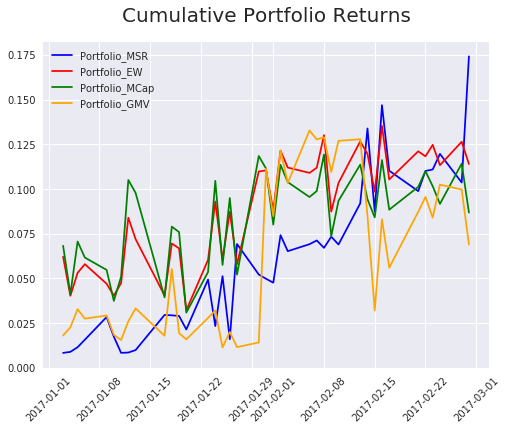

In [81]:
# Plot the cumulative portfolio returns over time
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(df.index,df["Portfolio_MSR_Returns"],color='b', label='Portfolio_MSR')
plt.plot(df.index,df["Portfolio_EW_Returns"],color='r', label='Portfolio_EW')
plt.plot(df.index,df["Portfolio_MCap_Returns"],color='g', label='Portfolio_MCap')
plt.plot(df.index,df["Portfolio_GMV_Returns"],color='orange', label='Portfolio_GMV')

plt.title('Cumulative Portfolio Returns')
plt.legend()
plt.xticks(rotation=45)
plt.show()

- sharpe ratios vary dramatically over time, historical data is not necessarly a good indication of the future
- **GMV tends to be better over time**

**Portfolio Standard Deviation(Volatility):**
- $\sigma_{portfolio}=\sqrt{w_T.\Sigma.w}$ 

In [84]:
cov_mat_annual = df_aux.iloc[:,:numstocks+1].cov()*252

portfolio_volatility = np.sqrt(np.dot(portfolio_weights_ew.T, np.dot(cov_mat_annual, portfolio_weights_ew)))
print(f"Portfolio_EW Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(mcap_weights.T, np.dot(cov_mat_annual, mcap_weights)))
print(f"Portfolio_MCAP Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(MSR_weights_array.T, np.dot(cov_mat_annual, MSR_weights_array)))
print(f"Portfolio_MSR Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(GMV_weights_array.T, np.dot(cov_mat_annual, GMV_weights_array)))
print(f"Portfolio_GMV Annual Volatility: {portfolio_volatility:0.3f}")

Portfolio_EW Annual Volatility: 0.085
Portfolio_MCAP Annual Volatility: 0.092
Portfolio_MSR Annual Volatility: 0.067
Portfolio_GMV Annual Volatility: 0.045


<br>
<br>
<br>

## 3 - Investment Models: CAPM and FamaFrench (3 and 5 factor)

In [131]:
FamaFrenchData = pd.read_csv('./data/FamaFrenchFactors.csv')
FamaFrenchData['Date'] = pd.to_datetime(FamaFrenchData['Date'], format='%Y-%m-%d')
FamaFrenchData.set_index(['Date'],inplace=True)
display(FamaFrenchData[:2])

,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.0
2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.0


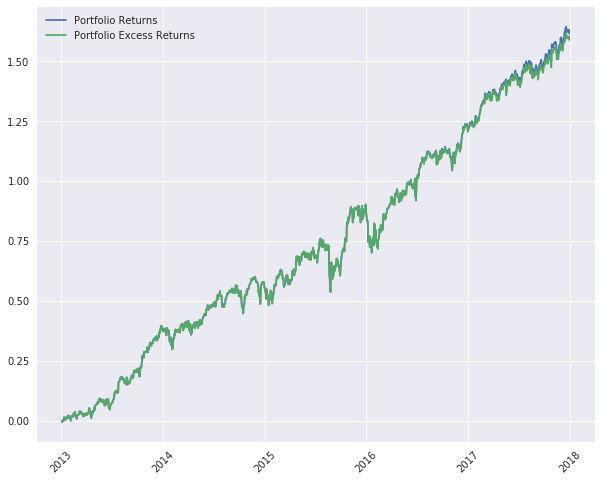

In [132]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio']-FamaFrenchData['RF']

# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio']]).cumprod()-1)
CumulativeExcessReturns = ((1+FamaFrenchData[['Portfolio_Excess']]).cumprod()-1)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(FamaFrenchData.index, CumulativeReturns, label='Portfolio Returns')
plt.plot(FamaFrenchData.index, CumulativeExcessReturns, label='Portfolio Excess Returns')
plt.xticks(rotation=45), plt.yticks(rotation=0) 
plt.legend()
plt.show()

<br>

**Capital Asset Pricing model (based on broad benchmarket portfolio)**:
- $E(R_P)-RF=\beta_P(E(R_B)-RF)$

In [109]:
# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

#r-squared: percentage variance of the regressed variable explained by the fitted regression
CAPM_fit = CAPM_model.fit()
print(f"CAPM model r-squared: {CAPM_fit.rsquared_adj:0.3f}")

CAPM model r-squared: 0.794


<br>

**Fama-French 3 factor model (more risk, more reward):** 
- $R_P=RF+\beta_M(R_M-RF)+b_{SMB}.SMB+b_{HML}.HML+\alpha$
- SMB: small minus big factor (small stocks tend to out-perform big stocks), $b_{SMB}$: exposure to SMB factor
- HML: high minus low factor (value versus growth, more ciclical), $b_{HML}$ exposure to HML
- $\alpha$: perfomance unexplained by other factors 
- small + value stocks tend to be the best (as oposed to large and growth stocks)

In [105]:
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)
FamaFrench_fit = FamaFrench_model.fit()
regression_adj_rsq = FamaFrench_fit.rsquared_adj

print("Fama French model r-squared: {:0.3f}".format(regression_adj_rsq))

Fama French model r-squared: 0.819


<br>

**Fama-French 5 factor model: + RMW (profitability) + CMA (Investment)**:
- The RMW: returns of companies with high vs low operating profitability 
- The CMA: returns of companies with aggressive investments versus conservative.

In [108]:
form='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA'
FamaFrench5_model = smf.ols(formula=form, data=FamaFrenchData)
FamaFrench5_fit = FamaFrench5_model.fit()
regression_adj_rsq = FamaFrench5_fit.rsquared_adj

print("5 factor model r-squared: {:0.3f}".format(regression_adj_rsq))

5 factor model r-squared: 0.837


<br>

**high beta means high market exposure** (CAPM example):
 - $\beta_P=\frac{Cov(R_P,R_B)}{Var(R_B)}$ or get from regression

In [111]:
#portfolio convariance
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()
covariance_coefficient = covariance_matrix.iloc[0, 1]
#benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()

portfolio_beta = covariance_coefficient / benchmark_variance
print(f"beta from formula: {portfolio_beta:0.3f}")

regression_beta = CAPM_fit.params['Market_Excess']
print(f"beta from regression: {regression_beta:0.3f}")

beta from formula: 0.974
beta from regression: 0.974


<br>

**p-value and statistical significance** (check if the SMB factor is needed, FamaFrench example)

In [112]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues["SMB"]

if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

smb_coeff = FamaFrench_fit.params['SMB']
print(f"The SMB coefficient is {smb_coeff:0.3f} and is {significant_msg}")

The SMB coefficient is -0.262 and is significant


<br>

**Unexplained return** (FamaFrench example)

In [113]:
portfolio_alpha = FamaFrench_fit.params["Intercept"]
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(f"Unxplained return: {portfolio_alpha_annualized:0.3f}")

Unxplained return: 0.047


<br>
<br>
<br>

## 4 - Understanding Risk

In [239]:
df = pd.read_csv('./data/USO.csv')
df['cum_rets'] = (1+df['USO']).cumprod()-1
df['Returns'] = df['USO']
df['Returns_perc'] = df['USO']*100.

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'],inplace=True)
#df = df.loc['2010-01-03':,:]
display(df[:2])

,USO,cum_rets,Returns,Returns_perc
Date,,,,
2007-01-03,-0.042636,-0.042636,-0.042636,-4.263558
2007-01-04,-0.040688,-0.081589,-0.040688,-4.068832


<br>

**Historical Drawdown**: how far have you fallen from the best point in history
  - $Drawdown=\frac{r_t}{RM}-1$ ($r_t$:cumulative return at time t, $RM$: running maximum)
  - good investments have little to no drawdown

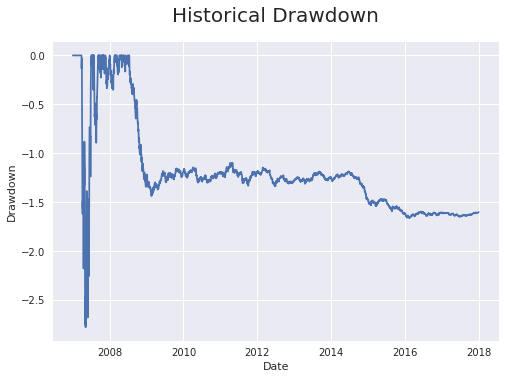

In [261]:
running_max = np.maximum.accumulate(df['cum_rets'])

drawdown = (df['cum_rets'])/running_max - 1
#only care about losses 
drawdown[drawdown > 0] = 0

plt.plot(df.index, drawdown)
plt.title('Historical Drawdown')
plt.ylabel('Drawdown'), plt.xlabel('Date')
plt.show()

<br>

**Value at risk**: threshold with a given confidence level that, historically, the losses have not exceeded (negative return in a single day)
  - VaR(95) = -2.3% means that in the worst 5% days, the loss exceeded 2.3%

**Conditional Value at risk** (CVar or expected shortfall): average of losses exceeding the VaR
  - CVaR(95) = -2.5% means that in the worst 5% of cases, losses on average exceeded 2.5% historically     
   

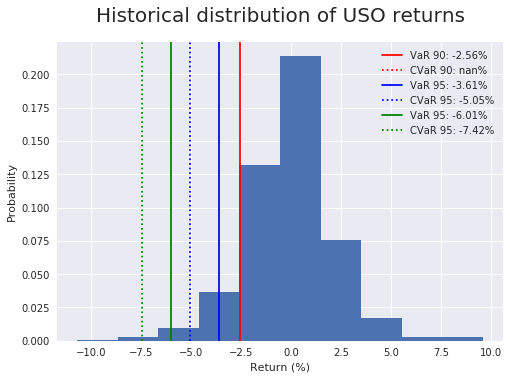

In [241]:
# Historical CVaR 90, 95 & 99
var_level = 90
var_90 = np.percentile(df['Returns_perc'], 100-var_level)
cvar_90 = df['Returns_perc'][df['Returns'] <= var_90].mean()

var_level = 95
var_95 = np.percentile(df['Returns_perc'], 100-var_level)
cvar_95 = df['Returns_perc'][df['Returns_perc'] <= var_95].mean()

var_level = 99
var_99 = np.percentile(df['Returns_perc'], 100-var_level)
cvar_99 = df['Returns_perc'][df['Returns_perc'] <= var_99].mean()

# Sort the returns for plotting
sorted_rets = sorted(df['Returns_perc'])

# Plot the probability of each return quantile
plt.hist(sorted_rets, density=True)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_90, color="r", linestyle="-", label='VaR 90: {0:.2f}%'.format(var_90))
plt.axvline(x=cvar_90, color='r', linestyle=':', label='CVaR 90: {0:.2f}%'.format(cvar_90))
plt.axvline(x=var_95, color="b", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle=':', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.axvline(x=var_99, color="g", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_99))
plt.axvline(x=cvar_99, color='g', linestyle=':', label='CVaR 95: {0:.2f}%'.format(cvar_99))
plt.title('Historical distribution of USO returns')
plt.ylabel('Probability'), plt.xlabel('Return (%)')
plt.legend()
plt.show()

<br>

**Parametric VaR**
  - Using probability distribution instead of discrete historical values (doesn't address non normality of returns but allows for more flexibility when doing models)

In [243]:
mu = np.mean(df['Returns'])
vol = np.std(df['Returns'])
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)
print(f"Mean: {mu:0.5f},\nVolatility: {vol:0.5f},\nVaR(95): {var_95:0.5f}")

Mean: -0.00029,
Volatility: 0.02189,
VaR(95): -0.03629


<br>

**Scaling Risk Estimates**
- To estimate 5-day VaR(95) = $var_{95}*\sqrt{N_{days}}$

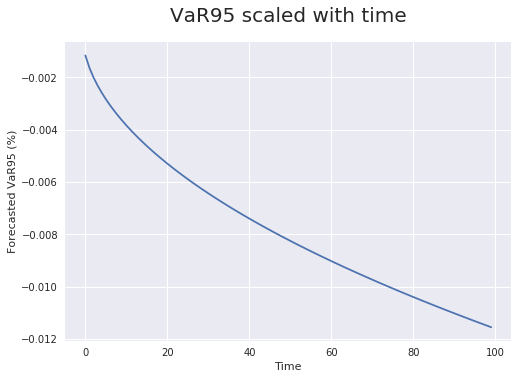

In [227]:
forecast_days = 5
forecast_var95_5day = var_95*np.sqrt(forecast_days)


forecasted_values = np.empty([100, 2])
for i in range(0,100):    
    forecasted_values[i, 0] = i    
    forecasted_values[i, 1] = var_95*np.sqrt(i+1)
    
# Plot the results
plt.plot(forecasted_values[:, 0],forecasted_values[:, 1])
plt.title('VaR95 scaled with time')
plt.xlabel('Time'), plt.ylabel('Forecasted VaR95 (%)')
plt.show()

<br>

**Random walks**
- Monte Carlo simulation, massive range of possible outcomes based on random walks, then analyse in the same way as historical values (with VaR for example)

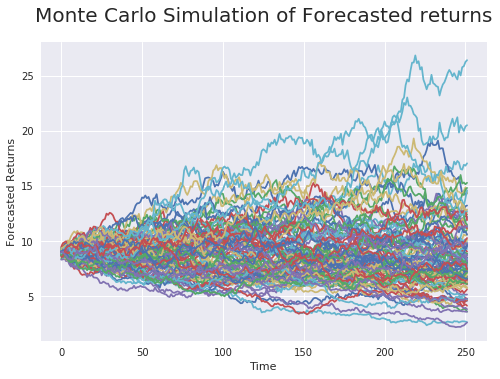

Parametric VaR(95): -3.61


In [265]:
mu = np.mean(df['Returns'])
vol = np.std(df['Returns'])
T = 252 # period
S0 = 10 # initial stock value

np.random.seed(seed=1)
sim_returns = []

# Loop through 100 simulations
for i in range(0,100):
    rand_rets = np.random.normal(mu, vol, T)   
    forecasted_values = S0*(rand_rets+1).cumprod()-1
    sim_returns.append(rand_rets)
    
    # Plot the Monte Carlo path
    plt.plot(range(0,T), forecasted_values)

# Show the simulations
plt.title('Monte Carlo Simulation of Forecasted returns')
plt.xlabel('Time'), plt.ylabel('Forecasted Returns')
plt.show()

var_95 = np.percentile(sim_returns, 5)
var_99 = np.percentile(sim_returns, 1)
print(f"Parametric VaR(95): {100*var_95:0.2f}")